In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image

# Gaussian process regression

<div style="color: green; font-weight:
bold">You seem to have implemented the gaussian process, and gaussian/naradaya-watson regression very well and clearly obtain the same conclusions than the sample solution. Even the execution time difference is relatively similar.</div>

In [2]:
def kernel(x_1, x_2, /, *, gamma=2, h=1, cutoff=1e-2):
    # dimensions: point of x_1, point of x_2, d=2
    r = np.linalg.norm(x_1[:,None] - x_2[None], axis=-1) / h
    kernel = np.exp(-r**gamma)
    return np.where(kernel > cutoff, kernel, 0)

def pad(array, p):
    if p < 0: return np.pad(array, (-p,0))
    if p > 0: return np.pad(array, (0,p))
    return array

def to_band_matrix(M):
    i, j = M.nonzero()
    max_diag = np.max(j - i)
    min_diag = np.min(j - i)
    
    band_matrix = np.stack([pad(M.diagonal(k), -k) for k in range(max_diag, min_diag-1, -1)])
    return band_matrix, np.abs(min_diag), np.abs(max_diag)

In [3]:
def calculate_z(coords, y, /, *, sigma=0, gamma=2, h=1, cutoff=1e-2):
    coord_parts = np.split(coords, 10)
    part_length = len(coord_parts[0])
    
    i = []
    j = []
    values = []
    
    for k, c_part in enumerate(coord_parts):
        A_part = kernel(c_part, coords, gamma=gamma, h=h, cutoff=cutoff)
        i_part, j_part = A_part.nonzero()
        i_part += k * part_length
        
        values.append(A_part[A_part != 0])
        i.append(i_part)
        j.append(j_part)
        
    values = np.concatenate(values)
    i = np.concatenate(i)
    j = np.concatenate(j)
    A = scipy.sparse.coo_array((values, (i,j)))
    A.setdiag(A.diagonal() + sigma**2)
    #print(f'nonzero elements: {A.nnz} ({A.nnz / np.prod(A.shape):.3%})')
    
    band_matrix, l, u = to_band_matrix(A)
    z = scipy.linalg.solve_banded((l, u), band_matrix, y)
    return z

Use of symmetry could further increase speed

In [4]:
def reconstruct_gauss(img, sigma=0.1, gamma=1.0, h=3, cutoff=1e-3):
    coords = np.stack(np.nonzero(img), axis=-1)
    y = img[*coords.T]
    
    z = calculate_z(coords, y, sigma=sigma, gamma=gamma, h=h, cutoff=cutoff)
    
    reconst = np.empty_like(img, dtype=float)
    n_rows, n_cols = img.shape
    
    for row in range(n_rows):
        for col in range(n_cols):
            point = np.array([row, col])
            b = kernel(coords, point, gamma=gamma, h=h, cutoff=cutoff)
            y_hat = b.T @ z
            reconst[row, col] = y_hat
            
    return reconst

## Nadaraya-Watson regression

In [5]:
def reconstruct_NW(img, gamma=2, h=3, cutoff=1e-3):
    coords = np.stack(np.nonzero(img), axis=-1)
    y = img[*coords.T]
    
    reconst = np.empty_like(img, dtype=float)
    n_rows, n_cols = img.shape
    
    for row in range(n_rows):
        for col in range(n_cols):
            point = np.array([row, col])
            b = kernel(coords, point, gamma=gamma, h=h, cutoff=cutoff)
            y_hat = b.T @ y / np.linalg.norm(b, axis=0, ord=1)
            reconst[row, col] = y_hat
            
    return reconst

## Apply to image

In [6]:
img = np.array(Image.open('cc_90.png'))

In [7]:
%%time
reconst_gauss = reconstruct_gauss(img, sigma=.0, gamma=1, h=7, cutoff=1e-3)

CPU times: user 54.2 s, sys: 2.04 s, total: 56.2 s
Wall time: 54.2 s


In [8]:
%%time
reconst_NW = reconstruct_NW(img, gamma=1.5, h=2, cutoff=1e-3)

CPU times: user 40.3 s, sys: 0 ns, total: 40.3 s
Wall time: 40.3 s


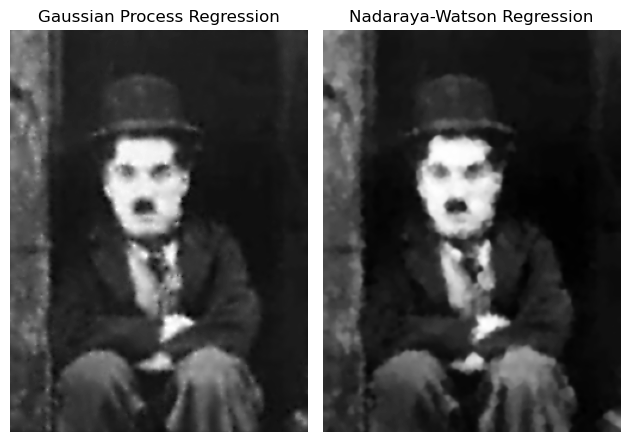

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(reconst_gauss, cmap='gray')
plt.title('Gaussian Process Regression')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconst_NW, cmap='gray')
plt.title('Nadaraya-Watson Regression')
plt.axis('off')

plt.tight_layout()
plt.show()

We can see Charlie Chaplin in the film "The Kid". The quality of the Gaussian process regression seems to be a bit better. Both methods take roughly the same amount of time in our implementation.

# Fitting Circles

(2431, 2)


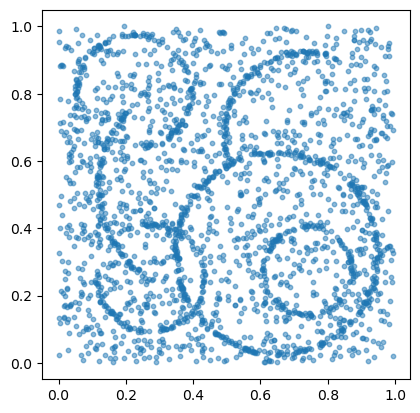

In [10]:
data = np.load('circles.npy')
print(data.shape)

plt.scatter(*data.T, s=10, alpha=.5)
plt.gca().set_aspect(1)
plt.show()

There seem to be two full circles, two almost full circles and two circle segments.

## RANSAC

<div style="color: green; font-weight:
bold">It is very hard to find any commentary, you even extended the results to include a step of penalty for big circles and their proportionally higher inliers. It worked, very impressive.</div>

In [11]:
points_per_set = 3
inlier_fraction = 0.1
# espcially towards the end, the inlier fraction is very low

In [12]:
def get_circle(points):
    x1, x2, x3 = points[:,0]
    y1, y2, y3 = points[:,1]
    
    M = np.array([[x1**2 + y1**2, x1, y1, 1],
                  [x2**2 + y2**2, x2, y2, 1],
                  [x3**2 + y3**2, x3, y3, 1]])
    
    A = +np.linalg.det(M[:,[  1,2,3]])
    B = -np.linalg.det(M[:,[0,  2,3]])
    C = +np.linalg.det(M[:,[0,1,  3]])
    D = -np.linalg.det(M[:,[0,1,2  ]])
    
    #assert np.abs(A) > 0.0001, f'need to devide by {A=}'
    
    r = np.sqrt((B**2 + C**2 - 4*A*D) / (4 * A**2))
    cx = - B / (2*A)
    cy = - C / (2*A)
    c = np.array([cx, cy])
    
    return c, r

In [13]:
def plot_ransac(data, fit, *, n_circles=6, alpha=.99, epsilon=.01):
    cs, rs = [], []
    current_data = data
    
    for i in range(1, n_circles+1):
        c, r, inliers = fit(current_data, alpha=alpha, epsilon=epsilon)
        cs.append(c)
        rs.append(r)
        
        circle = plt.Circle(c, radius=r, fill=False) # Create a circle
        plt.gca().add_patch(circle) # Add it to the plot
        plt.scatter(*current_data[~inliers].T, s=10, alpha=.5, zorder=-10)
        plt.scatter(*current_data[inliers].T, s=10, alpha=.5, zorder=-10)
        plt.gca().set_aspect(1)
        plt.title(f'circle no. {i}')
        plt.show()
        
        current_data = current_data[~inliers]
        
    plt.scatter(*current_data.T, s=10, alpha=.5, zorder=-10)
    plt.title('remaining data')
    plt.gca().set_aspect(1)
    plt.show()
    
    for c, r in zip(cs, rs):
        circle = plt.Circle(c, radius=r, fill=False) # Create a circle
        plt.gca().add_patch(circle) # Add it to the plot
    
    plt.scatter(*data.T, s=10, alpha=.5, zorder=-10)
    plt.title('all circles')
    plt.gca().set_aspect(1)
    plt.show()

In [14]:
def fit_circle(data, *, alpha, epsilon):
    best_r, best_c = None, None
    best_n, best_inliers = 0, None
    
    T = np.log(1 - alpha)/np.log(1 - inlier_fraction**points_per_set)
    T = int(np.ceil(T))
    
    for t in range(T):
        idx = np.random.choice(data.shape[0], 3, replace=False)
        c, r = get_circle(data[idx])
        dists = np.abs(r - np.linalg.norm(data - c, axis=-1))
    
        inliers = (dists < epsilon)
        n = np.sum(inliers)
        
        if n > best_n:
            best_r, best_c = r, c
            best_n, best_inliers = n, inliers
    
    return best_c, best_r, best_inliers

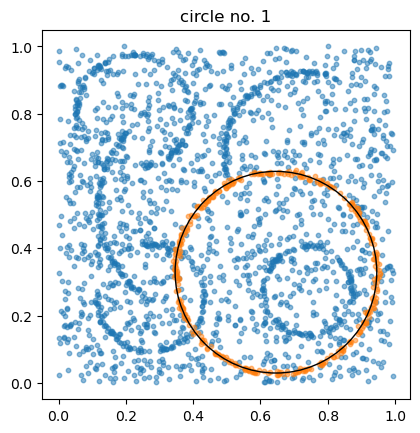

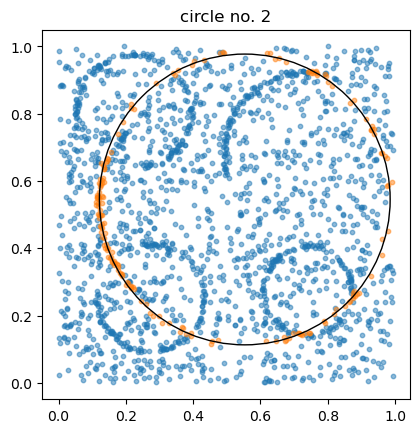

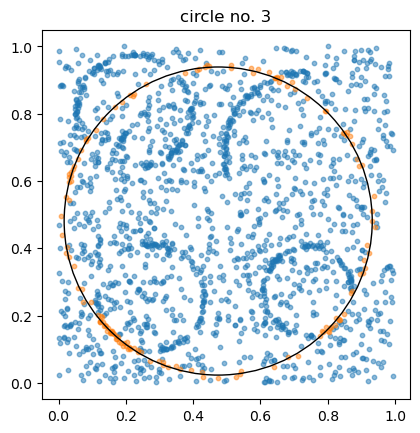

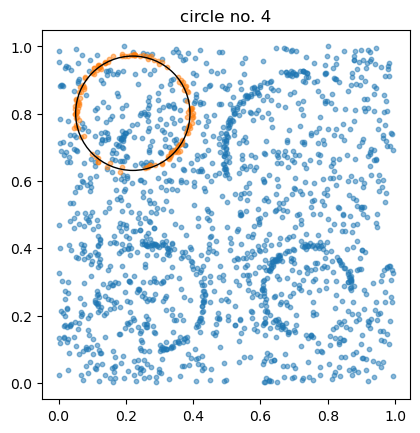

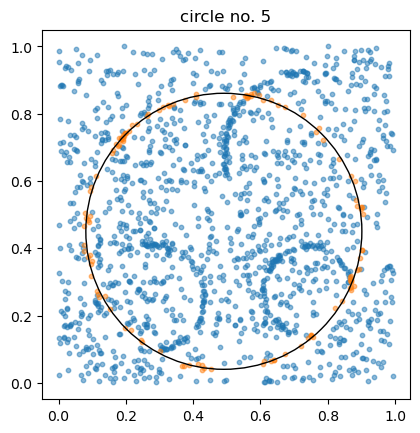

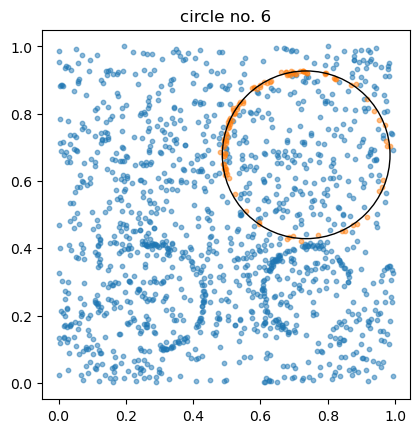

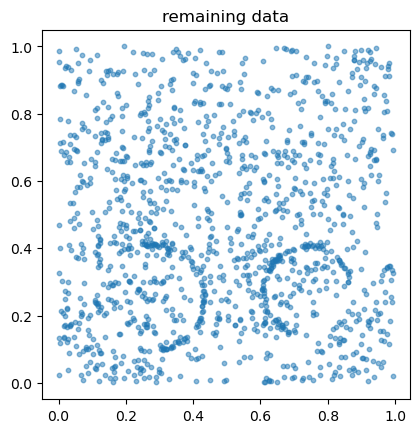

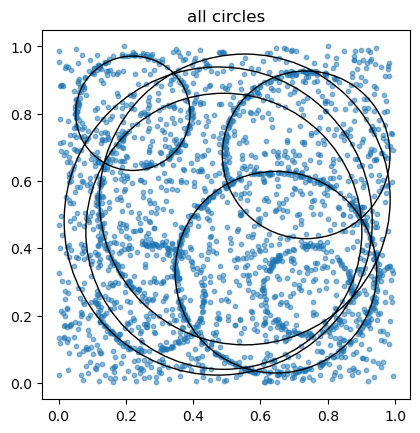

In [15]:
plot_ransac(data, fit_circle)

The algorithm prefers big circles over smaller ones because it tires to maximize the inlier count.

We also use a modified version where we devide the inlier count $n$ by the radius $r$ to obtain the number of inliers per length on the circle. This punishes the fit of big circles that have a lot of inliers due to thier size.
Empirically, deviding by the square root works even better, most likely becouse the data also contains circle segments.

In [16]:
def fit_circle_density(data, *, alpha, epsilon):
    best_r, best_c = None, None
    best_n, best_inliers = 0, None
    
    T = np.log(1 - alpha)/np.log(1 - inlier_fraction**points_per_set)
    T = int(np.ceil(T))
    
    for t in range(T):
        idx = np.random.choice(data.shape[0], 3, replace=False)
        c, r = get_circle(data[idx])
        dists = np.abs(r - np.linalg.norm(data - c, axis=-1))
    
        inliers = (dists < epsilon)
        n = np.sum(inliers)

        # punish big circles:
        # divide by the sqrt(r) to obtain points per length
        n = n / np.sqrt(r) 
        
        if n > best_n:
            best_r, best_c = r, c
            best_n, best_inliers = n, inliers
    
    return best_c, best_r, best_inliers

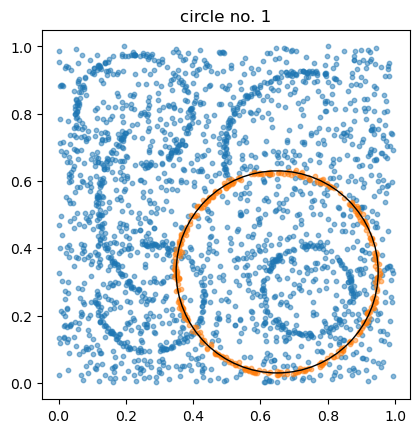

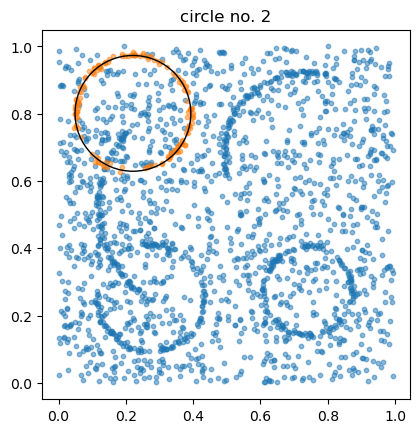

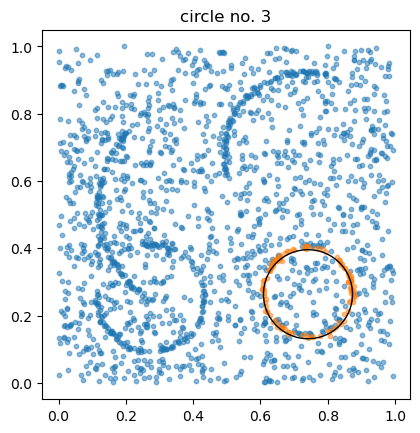

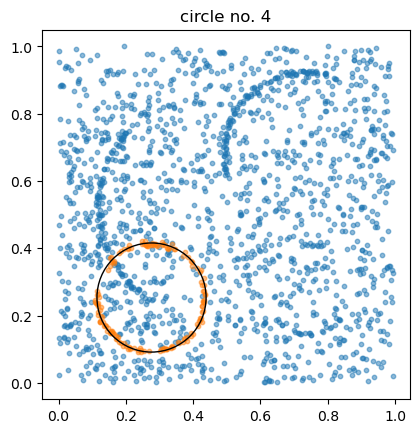

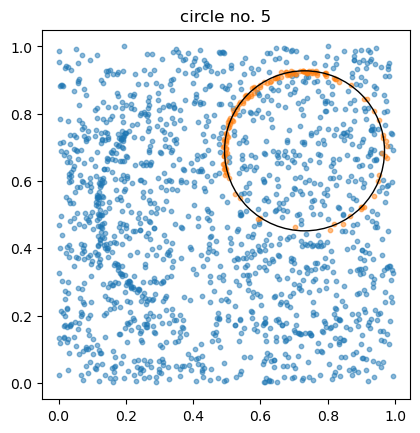

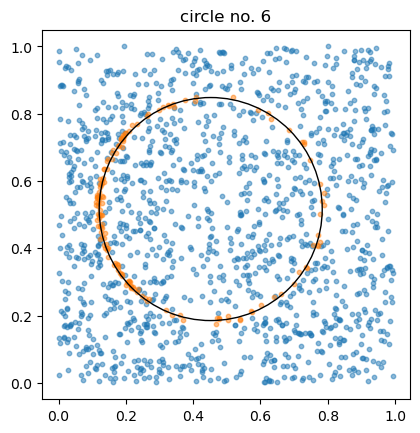

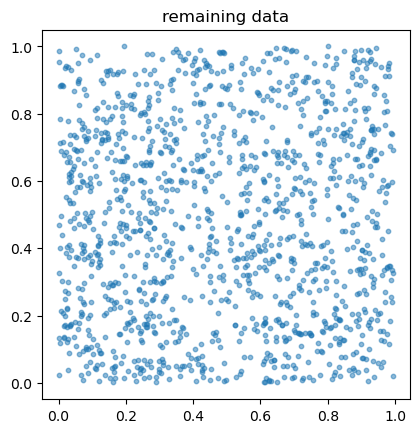

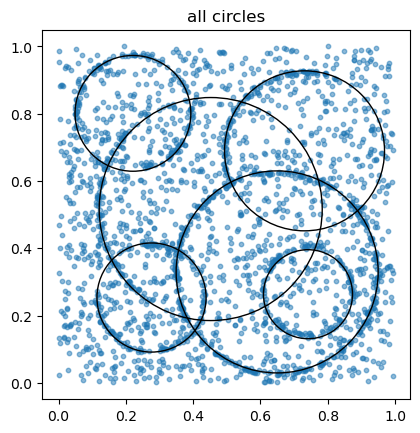

In [17]:
plot_ransac(data, fit_circle_density)

The modified version discovers all circles correctly (i.e., same as our human fit). The more complete circles are infered at first, as thier point density per length is bigger than for the circle segments.

## Non-linear least squares with the Levenberg-Marquardt algorithm

<div style="color: green; font-weight:
bold">It is very hard to find any commentary to the thorough and clear provided answer. Everything seems correct. You could have plotted all circles in to the same plot but that is an arbitrary stylistic choice.</div>

In [18]:
def circle_loss(x, points):
    cx, cy, r = x
    c = np.array([cx, cy])
    dists = r - np.linalg.norm(points - c, axis=-1)
    return dists

def fit_circle_LM(data, *, alpha, epsilon):
    best_r, best_c = None, None
    best_n, best_inliers = 0, None
    
    T = np.log(1 - alpha)/np.log(1 - inlier_fraction**points_per_set)
    T = int(np.ceil(T))
    
    for t in range(T):
        idx = np.random.choice(data.shape[0], 3, replace=False)
        c, r = get_circle(data[idx])
        dists = np.abs(r - np.linalg.norm(data - c, axis=-1))
    
        inliers = (dists < epsilon)
        
        n = np.sum(inliers)

        # punish big circles:
        n = n / np.sqrt(r)
        
        if n > best_n:
            best_r, best_c = r, c
            best_n, best_inliers = n, inliers
    
    sol = scipy.optimize.least_squares(circle_loss, x0=[*best_c, best_r], args=(data[best_inliers],))
    cx, cy, best_r = sol.x
    best_c = np.array([cx, cy])
    
    dists = np.abs(best_r - np.linalg.norm(data - best_c, axis=-1))
    best_inliers = (dists < epsilon)
    
    return best_c, best_r, best_inliers

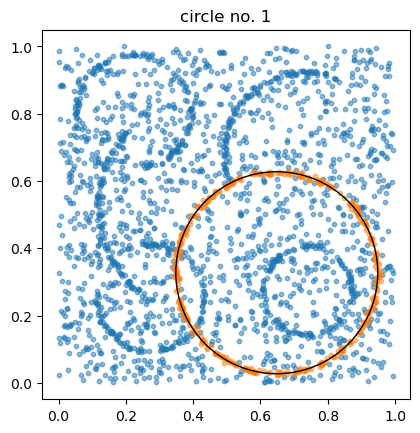

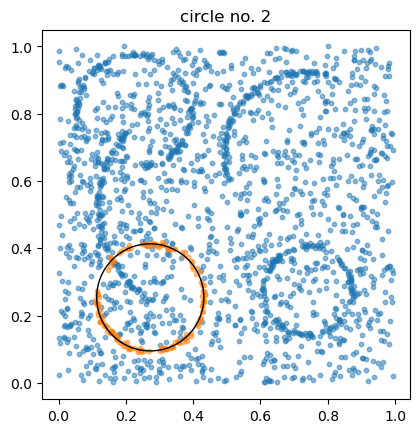

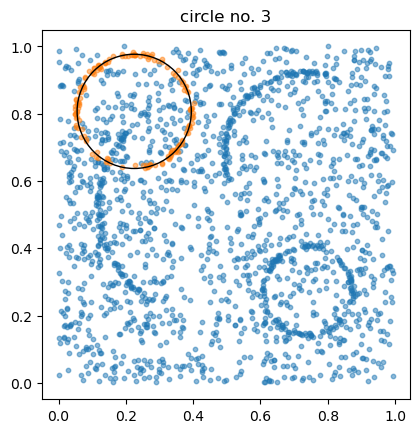

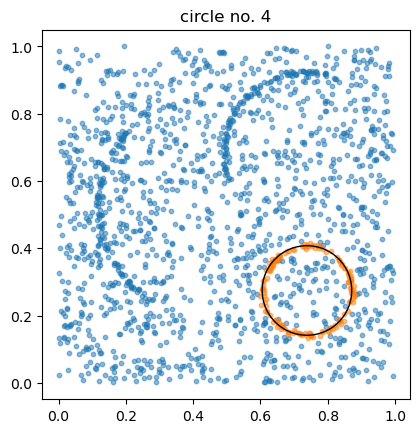

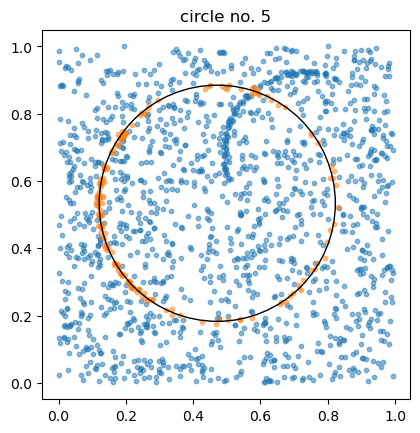

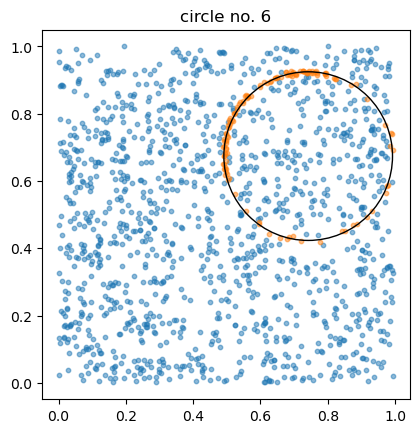

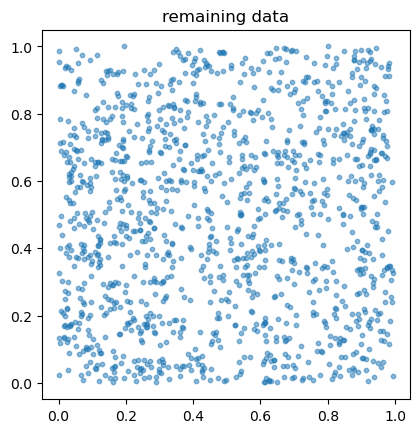

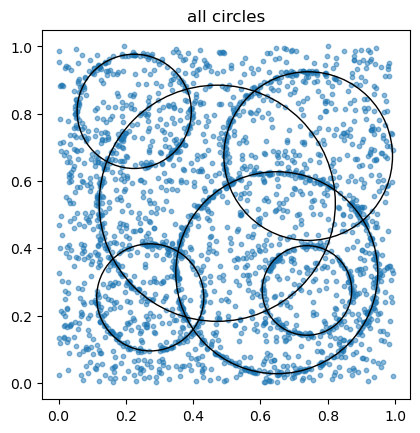

In [19]:
plot_ransac(data, fit_circle_LM, epsilon=0.01)

The fitting of all inliers doesn't improve the results by much as maximizing the number of inliers inside the $\varepsilon$-region already takes into account all points of a circle.

<div style="color: green; font-weight:
bold">Also seems to have been well implemented with on to how to improve even execution time.</div>

## Algebraic Distance

We obtain
\begin{align}
    \|x - c\|^2 - r^2 &= (x_1 - c_1)^2 + (x_2 - c_2)^2 - r^2\\
    &= x_1^2 + x_2^2 - 2 x_1 c_1 - 2 x_2 c_2 + c_1^2 + c_2^2 - r^2\\
    &= \tilde y - \tilde x \cdot \beta
\end{align}
with $\beta = (2 c_1, 2c_2, r^2 - c_1^2 - c_2^2)^T$.

In [20]:
def transformed_loss(beta, points):
    y_tilde = np.sum(points**2, axis=-1)
    x_tilde = np.concatenate([points, np.ones((points.shape[0],1))], axis=-1)
    return y_tilde - x_tilde @ beta

def fit_circle_algebraic(data, *, alpha, epsilon):
    best_r, best_c = None, None
    best_n, best_inliers = 0, None
    
    T = np.log(1 - alpha)/np.log(1 - inlier_fraction**points_per_set)
    T = int(np.ceil(T))
    
    for t in range(T):
        idx = np.random.choice(data.shape[0], 3, replace=False)
        c, r = get_circle(data[idx])
        dists = np.abs(r - np.linalg.norm(data - c, axis=-1))
    
        inliers = (dists < epsilon)
        
        n = np.sum(inliers)

        # punish big circles:
        n = n / np.sqrt(r)
        
        if n > best_n:
            best_r, best_c = r, c
            best_n, best_inliers = n, inliers
    
    beta0 = [*2*c, r**2 - c@c]
    sol = scipy.optimize.least_squares(transformed_loss, x0=beta0, args=(data[best_inliers],))
    beta = sol.x
    best_c = .5 * beta[:-1]
    best_r = np.sqrt(beta[-1] + best_c@best_c)
    
    #dists = np.abs(best_r - np.linalg.norm(data - best_c, axis=-1))
    #best_inliers = (dists < epsilon)
    
    return best_c, best_r, best_inliers

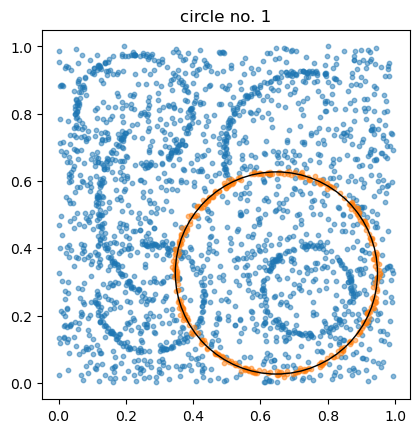

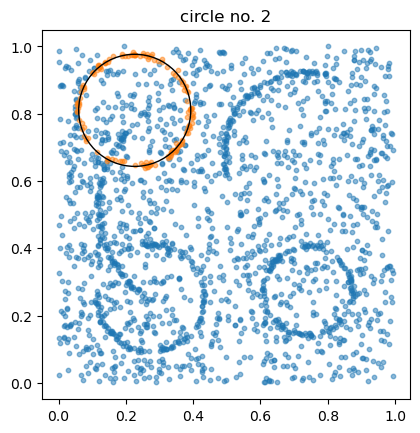

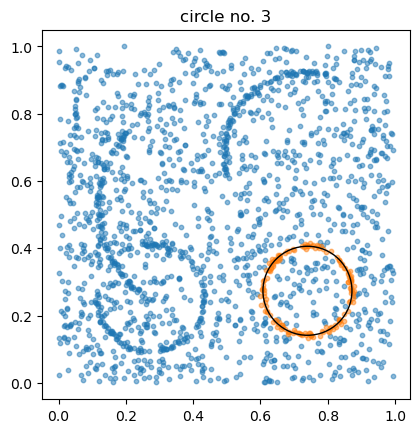

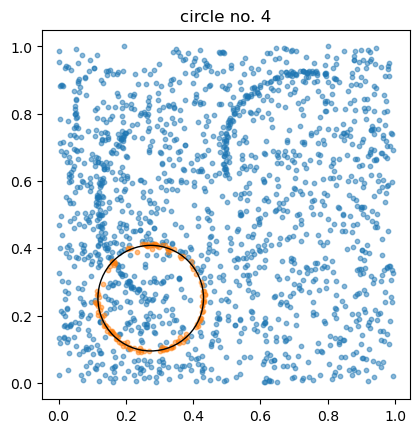

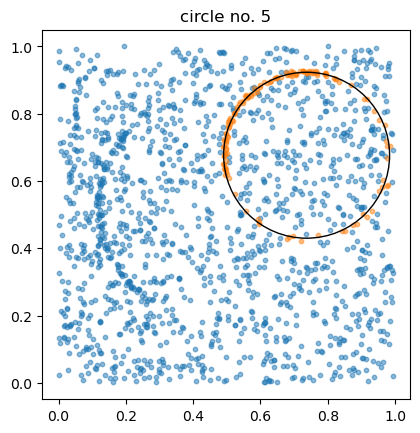

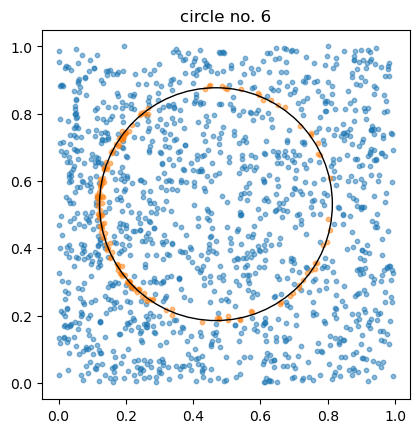

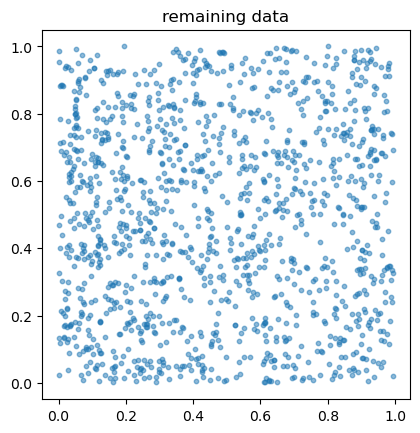

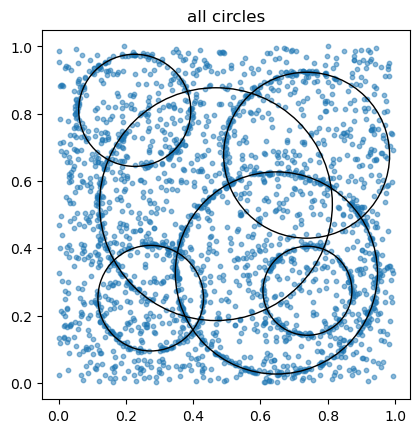

In [21]:
plot_ransac(data, fit_circle_algebraic)

The results are similar to the previous task.